In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from dleps_predictor2 import DLEPS

## Note: protobuf error can be resolved by downgrading it v3.20.1

In [18]:
dleps_p = DLEPS()
dleps_p.model[0].summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 277, 76)      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_8[0][0]                    
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 261, 9)       738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 251, 10)      1000        conv_2[0][0]                     
___________________________________________________________________________________________

In [19]:
import h5py

h5f = h5py.File('../../data/SMILE_train_demo2.h5', 'r')
smile_train = h5f['data'][:]
h5f2 = h5py.File('../../data/SMILE_test_demo2.h5', 'r')
smile_test = h5f2['data'][:]
h5f3 = h5py.File('../../data/appostasis_train_demo2.h5', 'r')
rna_train = h5f3['data'][:]
h5f4 = h5py.File('../../data/appostasis_test_demo2.h5', 'r')
rna_test = h5f4['data'][:]

print(rna_train.shape)
print(rna_test.shape)
print(smile_train.shape)
print(smile_test.shape)

(1026,)
(100,)
(1026, 277, 76)
(100, 277, 76)


In [20]:
his = dleps_p.train(smile_train, rna_train,(smile_test, rna_test), epochs=50,
                batch_size=32,
                shuffle=True,)

Train on 1026 samples, validate on 100 samples
Epoch 1/50
1026/1026 [==============================] - 1s 1ms/step - loss: 0.1509 - val_loss: 0.1440
Epoch 2/50
1026/1026 [==============================] - 1s 803us/step - loss: 0.1429 - val_loss: 0.1412
Epoch 3/50
1026/1026 [==============================] - 1s 864us/step - loss: 0.1447 - val_loss: 0.1429
Epoch 4/50
1026/1026 [==============================] - 1s 803us/step - loss: 0.1448 - val_loss: 0.1402
Epoch 5/50
1026/1026 [==============================] - 1s 776us/step - loss: 0.1409 - val_loss: 0.1399
Epoch 6/50
1026/1026 [==============================] - 1s 761us/step - loss: 0.1402 - val_loss: 0.1402
Epoch 7/50
1026/1026 [==============================] - 1s 916us/step - loss: 0.1383 - val_loss: 0.1393
Epoch 8/50
1026/1026 [==============================] - 1s 995us/step - loss: 0.1394 - val_loss: 0.1389
Epoch 9/50
1026/1026 [==============================] - 1s 927us/step - loss: 0.1384 - val_loss: 0.1389
Epoch 10/50
1026/10

[[1.         0.20187762]
 [0.20187762 1.        ]]
R2 Score: 0.036991481580349705
MSE Loss: 0.13697097753716247


Text(0, 0.5, 'predicted')

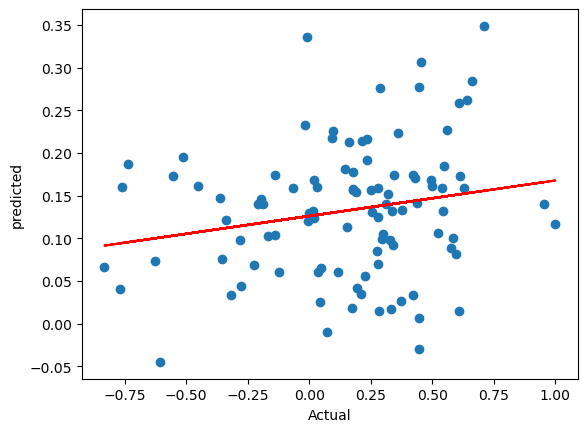

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
pred = dleps_p.model[0].predict(smile_test)
print(np.corrcoef(rna_test, pred.ravel()))
r2 = r2_score(rna_test, pred)
print(f'R2 Score: {r2}')
mse = mean_squared_error(rna_test, pred)
print(f'MSE Loss: {mse}')
# fig = plt.figure()
plt.scatter(rna_test, pred)
m, b = np.polyfit(rna_test, pred, 1)
plt.plot(rna_test, m * rna_test + b, 'r');
plt.xlabel('Actual')
plt.ylabel('predicted')
# fig.set_facecolor("white")

In [22]:
# Save model
from joblib import dump, load
dump(dleps_p.model[0], 'model.joblib')

['model.joblib']

In [23]:
model = load('model.joblib')
model

In [24]:
h5f_zinc = h5py.File('../../data/SMILES_zinc_world.h5', 'r')
world_test = h5f_zinc['data'][:]
world_pred = model.predict(world_test)
world_pred

array([[0.0725529 ],
       [0.08412603],
       [0.03728059],
       ...,
       [0.07069267],
       [0.06799851],
       [0.17354915]], dtype=float32)

In [25]:
# Merge test results column to the test dataset
import pandas as pd
zinc_world_test = pd.read_csv('../../data/WORLD_test.csv')
zinc_world_test.head()

,zinc_id,smiles,smiles_rdkit
0,ZINC000095618893,CN[C@H]1CC[C@H]2Nc3c(O)cc(C(N)=O)cc3[C@@H]2C1,CN[C@H]1CC[C@H]2Nc3c(O)cc(C(N)=O)cc3[C@@H]2C1
1,ZINC000095618901,C[C@@H]1CN(S(=O)(=O)O)CCc2ccc(Cl)cc21,C[C@@H]1CN(S(=O)(=O)O)CCc2ccc(Cl)cc21
2,ZINC000095618909,CC(=O)N[C@H]1CC[C@H]2Nc3ccc(C(N)=O)cc3[C@@H]2C1,CC(=O)N[C@H]1CC[C@H]2Nc3ccc(C(N)=O)cc3[C@@H]2C1
3,ZINC000095618925,O=C(O)[C@@H]1O[C@H](O[n+]2ccccc2)[C@@H](O)[C@H...,O=C(O)[C@@H]1O[C@H](O[n+]2ccccc2)[C@@H](O)[C@H...
4,ZINC000000000513,COc1ccccc1OC[C@H](O)CNC(C)C,COc1ccccc1OC[C@H](O)CNC(C)C


In [26]:
zinc_world_test['results'] = world_pred
zinc_world_test

,zinc_id,smiles,smiles_rdkit,results
0,ZINC000095618893,CN[C@H]1CC[C@H]2Nc3c(O)cc(C(N)=O)cc3[C@@H]2C1,CN[C@H]1CC[C@H]2Nc3c(O)cc(C(N)=O)cc3[C@@H]2C1,0.072553
1,ZINC000095618901,C[C@@H]1CN(S(=O)(=O)O)CCc2ccc(Cl)cc21,C[C@@H]1CN(S(=O)(=O)O)CCc2ccc(Cl)cc21,0.084126
2,ZINC000095618909,CC(=O)N[C@H]1CC[C@H]2Nc3ccc(C(N)=O)cc3[C@@H]2C1,CC(=O)N[C@H]1CC[C@H]2Nc3ccc(C(N)=O)cc3[C@@H]2C1,0.037281
3,ZINC000095618925,O=C(O)[C@@H]1O[C@H](O[n+]2ccccc2)[C@@H](O)[C@H...,O=C(O)[C@@H]1O[C@H](O[n+]2ccccc2)[C@@H](O)[C@H...,0.107676
4,ZINC000000000513,COc1ccccc1OC[C@H](O)CNC(C)C,COc1ccccc1OC[C@H](O)CNC(C)C,0.059833
...,...,...,...,...
4152,ZINC000101144764,C[N+]1(C)[C@@H]2C[C@H](OC(=O)C(O)(c3cccs3)c3cc...,C[N+]1(C)[C@@H]2C[C@H](OC(=O)C(O)(c3cccs3)c3cc...,0.060864
4153,ZINC000118913164,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=C(CCC(=O)C4)[C@...,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=C(CCC(=O)C4)[C@...,0.033594
4154,ZINC000085537078,CC[C@]12C=CCN3CC[C@@]4(c5cc([C@@]6(C(=O)OC)C[C...,CC[C@]12C=CCN3CC[C@@]4(c5cc([C@@]6(C(=O)OC)C[C...,0.070693
4155,ZINC000085537089,CCCN(CCC)C(=O)[C@@H](CCC(=O)OCCCN1CCN(CCOC(=O)...,CCCN(CCC)C(=O)[C@@H](CCC(=O)OCCCN1CCN(CCOC(=O)...,0.067999


In [27]:
zinc_world_test_sorted = zinc_world_test.sort_values(by='results', ascending=False)
zinc_world_test_sorted.head()

,zinc_id,smiles,smiles_rdkit,results
1510,ZINC000000056646,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,0.380811
679,ZINC000003929022,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,0.375881
514,ZINC000000004760,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,0.352869
1701,ZINC000008220548,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,0.348708
1807,ZINC000004095793,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,0.347759


In [28]:
zinc_world_test_sorted.to_csv("../../data/zinc_world_output_1.csv", index=False)

In [29]:
import pandas as pd
df_zinc_output = pd.read_csv("../../data/zinc_world_output_1.csv")
df_zinc_output.head()

,zinc_id,smiles,smiles_rdkit,results
0,ZINC000000056646,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,0.380811
1,ZINC000003929022,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,0.375881
2,ZINC000000004760,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,0.352869
3,ZINC000008220548,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,0.348708
4,ZINC000004095793,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,0.347759


In [30]:
df_zinc_output_top_100 = df_zinc_output[:100]
df_zinc_output_top_100

,zinc_id,smiles,smiles_rdkit,results
0,ZINC000000056646,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,CC(C)NC[C@@H](O)COc1cccc2[nH]ccc12,0.380811
1,ZINC000003929022,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc2...,0.375881
2,ZINC000000004760,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,O[C@](CCN1CCCC1)(c1ccccc1)C1CCCCC1,0.352869
3,ZINC000008220548,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,0.348708
4,ZINC000004095793,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@...,0.347759
...,...,...,...,...
95,ZINC000253476025,CC(C)[N@+]1(C)[C@H]2CC[C@@H]1C[C@H](OC(=O)[C@H...,CC(C)[N@+]1(C)[C@H]2CC[C@@H]1C[C@H](OC(=O)[C@H...,0.290118
96,ZINC000008552159,N[C@H](CCC(=O)N[C@H](CS[C@@H]1CCO[P@@](=O)(N(C...,N[C@H](CCC(=O)N[C@H](CS[C@@H]1CCO[P@@](=O)(N(C...,0.289406
97,ZINC000003779720,CC(C)c1cc2c(cc1S(=O)(=O)O)[C@@]1(C)CCC[C@@](C)...,CC(C)c1cc2c(cc1S(=O)(=O)O)[C@@]1(C)CCC[C@@](C)...,0.289152
98,ZINC000077312930,O=C(Nc1c(Cl)c[n+]([O-])cc1Cl)c1ccc(OC(F)F)c(OC...,O=C(Nc1c(Cl)c[n+]([O-])cc1Cl)c1ccc(OC(F)F)c(OC...,0.289059


In [31]:
df_zinc_output_top_100.to_csv("../../data/zinc_world_top_100.csv", index=False)

In [32]:
### End

In [33]:
# y_pred = dleps_p.model[0].predict(smile_train)
# rna_train = np.reshape(rna_train, y_pred.shape)
# print(rna_train.shape)
# print(y_pred.shape)
# corr = np.array([0.])
# corr=np.hstack((corr,np.corrcoef(rna_train[0],y_pred[0])[0, 1]))
# print(corr)


In [34]:
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

# y_pred = dleps_p.model[0].predict(smile_train)

# corr = np.array([0.])

# print(smile_train.shape)

# print(y_pred.shape)
# for i in range(smile_train.shape[0]):
    
#     corr=np.hstack((corr,np.corrcoef(rna_train[i],y_pred[i])[0, 1]))
# plt.hist(corr,50)
# plt.show()
# print(corr.mean())

In [35]:
# corr

In [36]:
# from scipy.stats import gaussian_kde

# def density(x,y):
#     xy = np.vstack([x,y])
#     return gaussian_kde(xy)(xy)

Training set

In [37]:
# n = 10  # how many digits we will display
# sam = 50
# plt.figure(figsize=(20, 6))

# with plt.style.context(['ggplot']):
#     plt.figure(figsize=(20, 6))
#     for i in range(10):
#         # display original
#         ax = plt.subplot(3, n, i + 1)

#         plt.scatter(y_pred[sam+i],rna_train[sam+i],c=density(y_pred[sam+i],rna_train[sam+i]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*10+1)

#         plt.scatter(y_pred[sam+i+10],rna_train[sam+i+10],c=density(y_pred[sam+i+10],rna_train[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*20+1)

#         plt.scatter(y_pred[sam+i+20],rna_train[sam+i+20],c=density(y_pred[sam+i+20],rna_train[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


# plt.tight_layout()
# #plt.savefig('../analysis_plot/Figures/Train_Samples3_density.svg', format='svg')

In [38]:
# plt.style.available

Analysis of Testing set

In [39]:
# y_pred2 = dleps_p.model[0].predict(smile_test)

# corr = np.array([0.])

# print(smile_test.shape)

# print(y_pred2.shape)
# for i in range(smile_test.shape[0]):
#     corr=np.hstack((corr,np.corrcoef(rna_test[i],y_pred2[i])[0, 1]))
# plt.hist(corr,50)
# plt.show()
# print(corr.mean())

Testing set

In [40]:
# n = 10  # how many digits we will display
# sam = 50
# with plt.style.context(['science','no-latex']):
#     plt.figure(figsize=(20, 6))
#     for i in range(10):
#         # display original
#         ax = plt.subplot(3, n, i + 1)

#         plt.scatter(y_pred2[sam+i],rna_test[sam+i],s=8,c=density(y_pred2[sam+i],rna_test[sam+i]),cmap="coolwarm")
#         ax = plt.subplot(3, n, i + 1*10+1)

#         plt.scatter(y_pred2[sam+i+10],rna_test[sam+i+10],c=density(y_pred2[sam+i+10],rna_test[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*20+1)

#         plt.scatter(y_pred2[sam+i+20],rna_test[sam+i+20],c=density(y_pred2[sam+i+20],rna_test[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


# plt.tight_layout()
# #plt.savefig('../analysis_plot/Figures/Test_Samples3_density.svg', format='svg')